In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import xgboost as xgb
from scipy import stats

from statsmodels.tsa.stattools import adfuller

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

/Users/dkurra/miniconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
Using TensorFlow backend.


In [2]:
import statsmodels.api as sm
import matplotlib
import itertools

Import the CTA rides dataset downloaded from https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f

In [3]:
rides_data = pd.read_csv('./CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')

In [4]:
rides_data.shape

(962546, 5)

A total of 962546 rows with 5 columns

In [5]:
rides_data.dtypes

station_id      int64
stationname    object
date           object
daytype        object
rides           int64
dtype: object

In [6]:
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962546 entries, 0 to 962545
Data columns (total 5 columns):
station_id     962546 non-null int64
stationname    962546 non-null object
date           962546 non-null object
daytype        962546 non-null object
rides          962546 non-null int64
dtypes: int64(2), object(3)
memory usage: 36.7+ MB


understanding each of the column
- station_id - categorical, nominal variable
- station_name/stationname - categorical, nominal variable
- date - quantitative
- rides - quantitative
- daytype - categorical, nominal variable


Sneak peek of the first few entries in the table

In [7]:
rides_data.head()

,station_id,stationname,date,daytype,rides
0,40850,Library,10/09/2004,A,1057
1,40780,Central Park,06/18/2010,W,1154
2,41500,Montrose-Brown,10/30/2001,W,2116
3,40500,Washington/State,10/26/2006,W,0
4,41090,Monroe/State,07/07/2010,W,9431


Any missing rows that needs to taken care of?

In [8]:
# checking for missing values
rides_data.isnull().sum().max()

0

The dataset has no rows with missing values

Number of stations available for Chicago transportation

In [9]:
rides_data['stationname'].nunique()

148

Names of the 148 station at the Chicago Transportation

In [10]:
rides_data['stationname'].unique()

array(['Library', 'Central Park', 'Montrose-Brown', 'Washington/State',
       'Monroe/State', 'Sheridan', 'UIC-Halsted', "Irving Park-O'Hare",
       'State/Lake', 'Randolph/Wabash', 'Harrison', 'Pulaski-Forest Park',
       'Southport', "Montrose-O'Hare", 'Argyle', 'Cicero-Cermak',
       'Western/Milwaukee', "Addison-O'Hare", 'Berwyn', 'Forest Park',
       'Kedzie-Midway', 'Washington/Wells', 'California/Milwaukee',
       'Pulaski-Cermak', 'Fullerton', 'Cermak-Chinatown', 'Damen-Brown',
       'Halsted-Orange', 'LaSalle/Van Buren', 'Rosemont', 'Linden',
       'Damen-Cermak', 'Austin-Forest Park', '51st', 'Pulaski-Orange',
       'Belmont-North Main', 'Clark/Division', 'Ashland-Lake', '79th',
       'Ashland-Orange', 'Western-Brown', 'Lake/State', 'Francisco',
       '69th', 'Jackson/Dearborn', 'Noyes', 'Racine', "Harlem-O'Hare",
       'Laramie', 'California-Cermak', 'Kimball', 'Polk', 'Bryn Mawr',
       'Irving Park-Brown', 'Halsted/63rd', 'Kedzie-Brown',
       'Kedzie-Cermak'

Of all the 148 stations at CTA (Chicago Transport Authority), which is the most famous station interms of number of rides that were taken since 2001?

In [11]:
rides_data.groupby(['stationname']).sum().sort_values(by='rides', ascending=False)

,station_id,rides
stationname,,
Clark/Lake,272807280,94799999
Lake/State,281496620,94264858
Chicago/State,279994750,87346160
95th/Dan Ryan,272228500,70781223
Belmont-North Main,279116600,70676132
...,...,...
King Drive,277941840,3752102
Kostner,274374800,2295154
Cermak-McCormick Place,68454980,2139792


Station named `Clark/Lake` with stationid `272807280` has most number of rides till date and least is with `Homan` the station with stationid `1288980`

Given that station_name feature is a high cardinal feature, we can drop this columns from further analysis and instead we will use station_id feature for further analysis

In [12]:
rides_data.drop('stationname', axis=1, inplace=True)

In [13]:
rides_data.head()

,station_id,date,daytype,rides
0,40850,10/09/2004,A,1057
1,40780,06/18/2010,W,1154
2,41500,10/30/2001,W,2116
3,40500,10/26/2006,W,0
4,41090,07/07/2010,W,9431


convert the `date` to `pandas` date representation

In [14]:
rides_data["date"] = pd.to_datetime(rides_data["date"])

In [15]:
rides_data.date.min()

Timestamp('2001-01-01 00:00:00')

In [16]:
rides_data.date.max()

Timestamp('2019-06-30 00:00:00')

The dataset has entries starting from Jan 1st, 2001 to June 30, 2019. This is good chuck of historical data that could be used for understanding various aspects of CTA ridership

From the cta official website, here is encoded meaning of the daytype columns
 - W=Weekday
 - A=Saturday
 - U=Sunday/Holiday.

One way we could process this information into machine learning models is to encode them. One of the most commonly used encoding strategy is using label encoding

In [17]:
train_test_set = rides_data
lb = preprocessing.LabelEncoder()
day_catergories = (list(train_test_set.daytype))
train_test_set['day_type_encoded'] = lb.fit_transform(day_catergories)

In [18]:
train_test_set.head()

,station_id,date,daytype,rides,day_type_encoded
0,40850,2004-10-09,A,1057,0
1,40780,2010-06-18,W,1154,2
2,41500,2001-10-30,W,2116,2
3,40500,2006-10-26,W,0,2
4,41090,2010-07-07,W,9431,2


In [19]:
train_test_set['day_type_encoded'].unique()

array([0, 2, 1])

`daytype` are encoded as following labels:
- 0 -  A (Saturday)
- 2 -  W (Weekday)
- 1 -  U (Sunday/Holiday)

Number of entries with daytype as Saturday (0 or A)

In [20]:
saturday_count = train_test_set[train_test_set['day_type_encoded'] == 0].count()

Number of entries with daytype as Weekday (1 or W)

In [21]:
weekday_count = train_test_set[train_test_set['day_type_encoded'] == 1].count()

Number of entries with daytype as Sunday/Holiday (2 or U)

In [22]:
holiday_count = train_test_set[train_test_set['day_type_encoded'] == 2].count()

In [23]:
saturday_count + weekday_count + holiday_count == train_test_set.count()

station_id          True
date                True
daytype             True
rides               True
day_type_encoded    True
dtype: bool

## Dealing with duplicate entries

All the rides taken at station on the same date are grouped and added

In [24]:
train_test_set = train_test_set.groupby(['station_id', 'daytype', 'date', 'day_type_encoded']).sum().reset_index()

In [25]:
train_test_set.shape

(961928, 5)

The entries as sorted wrt to the time the values of were recorded (i.e date)

In [26]:
train_test_set.sort_values(by=['date'])

,station_id,daytype,date,day_type_encoded,rides
176381,40280,U,2001-01-01,1,700
584029,40920,U,2001-01-01,1,474
183136,40290,U,2001-01-01,1,540
142636,40230,U,2001-01-01,1,788
766324,41220,U,2001-01-01,1,1763
...,...,...,...,...,...
217985,40340,U,2019-06-30,1,2889
861938,41360,U,2019-06-30,1,488
686368,41080,U,2019-06-30,1,561
915948,41460,U,2019-06-30,1,1561


Total of 961928 entries dated from 2001-01-01 to 2019-06-30

## Feature engineering:

Feature engineering:
- Add a quater of the year in which the rides were recorded
- Add month of the year in which the rides were recorded
- Add Day of the year in which the rides were recorded

In [27]:
train_test_set['year'] = train_test_set['date'].apply(lambda x: x.year)
train_test_set['quarter'] = train_test_set['date'].apply(lambda x: x.quarter)
train_test_set['month'] = train_test_set['date'].apply(lambda x: x.month)
train_test_set['day'] = train_test_set['date'].apply(lambda x: x.day)

time_sliced_data = train_test_set.loc[:,['date','rides', 'year','quarter', 'month', 'day', 'day_type_encoded']]
time_sliced_data.sort_values('date', inplace=True, ascending=True)
time_sliced_data = time_sliced_data.reset_index(drop=True)

time_sliced_data["weekday"] = (time_sliced_data["day_type_encoded"] == 2).astype(int)
time_sliced_data['saturday'] = (time_sliced_data["day_type_encoded"] == 0).astype(int)
time_sliced_data['sun_holiday'] = (time_sliced_data["day_type_encoded"] ==1).astype(int)

In [28]:
time_sliced_data.head()

,date,rides,year,quarter,month,day,day_type_encoded,weekday,saturday,sun_holiday
0,2001-01-01,700,2001,1,1,1,1,0,0,1
1,2001-01-01,474,2001,1,1,1,1,0,0,1
2,2001-01-01,540,2001,1,1,1,1,0,0,1
3,2001-01-01,788,2001,1,1,1,1,0,0,1
4,2001-01-01,1763,2001,1,1,1,1,0,0,1


Are rides are normally distributed? We could do a normality test to check if the data is nearly normal. A normal distribution could be useful beacuse of the central limit Theorem

In [29]:
significance = 0.05
stat, p_value = stats.normaltest(time_sliced_data.rides)
print('statistic=%.3f, p_value=%.3f' % (stat, p_value))

if p_value > significance:
    print('Data distribution is Gaussian')
else:
    print('Data distribution is not Gaussian')

statistic=420421.411, p_value=0.000
Data distribution is not Gaussian


part-b of normality test, we could visually verify if the ride distribution follows normal distribution using
- histogram
- normal propbability plot 

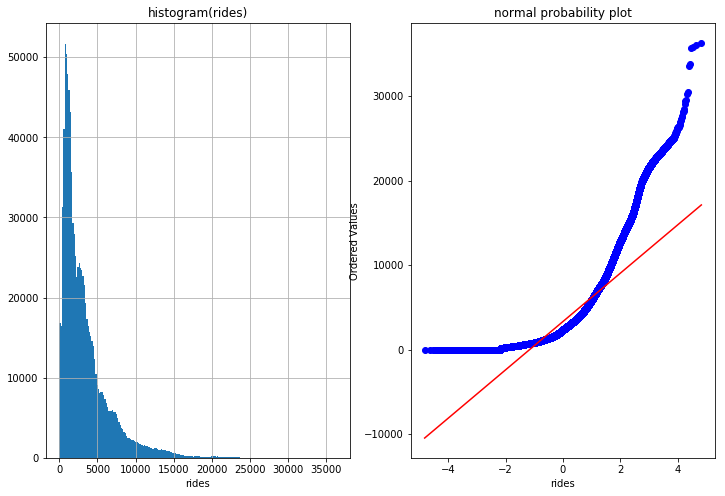

In [30]:
figure = plt.figure(figsize=(12,8))

ax1 = figure.add_subplot(1,2,1)
time_sliced_data['rides'].hist(bins=12*(2019-2001)) # 12 months
ax1.set_xlabel('rides')
ax1.set_title('histogram(rides)')


ax1 = figure.add_subplot(1,2,2)
stats.probplot(time_sliced_data['rides'], plot=plt)

ax1.set_xlabel('rides')
ax1.set_title('normal probability plot')

plt.show()

conclusion: Right skewed with mean of 3320 and median of 2324 rides

Given that the data is not normally distributed we can find how much the distribution departs from normal distribution using kurtosis and skew

kurtosis of rides distribution is %.02f 5.941795350054621
Skew of rides distribution is %.02f 2.108571517979914


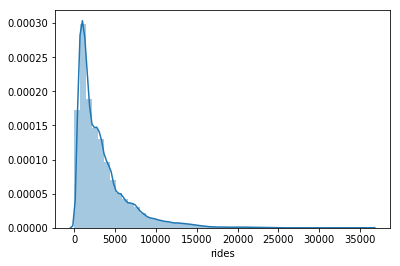

In [31]:
sns.distplot(time_sliced_data.rides)
print('kurtosis of rides distribution is %.02f', stats.kurtosis(time_sliced_data.rides))
print('Skew of rides distribution is %.02f', stats.skew(time_sliced_data.rides))

- kurtosis is greater than zero implying a heavy distribution in the tails. Normal distribution tends to have kurtosis very close to zero
- Rides are right skewed

To start with lets just simply plot all the rides on all the dates

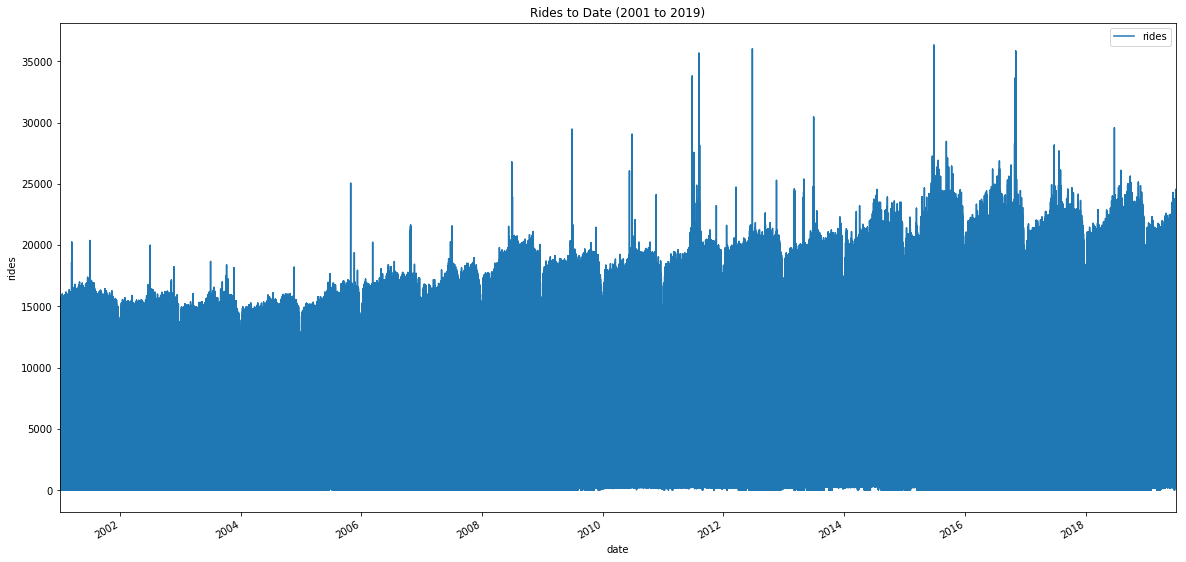

In [32]:
time_sliced_data_by_date = time_sliced_data.loc[:,['date','rides']]
time_sliced_data_by_date.set_index('date',inplace=True)
time_sliced_data_by_date.plot(figsize=(20, 10))
plt.ylabel('rides')
plt.title('Rides to Date (2001 to 2019)')
plt.show();

plotting all the rides to date is not giving much of a meaning ful insight, might need to use other data visualizations to understand the insights provided by the timeseries. We could explor Boxplots, contingency tables, segemented bar plots, mosaic plots etc


## EDA

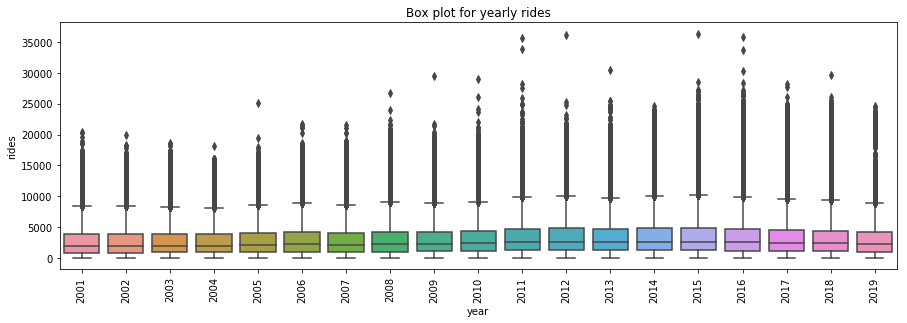

In [33]:
figure = plt.figure(figsize=(15,10))
ax1 = figure.add_subplot(2,1,1)
sns.boxplot(x="year", y="rides", data = time_sliced_data)

ax1.set_xlabel('year')
ax1.set_title('Box plot for yearly rides')
ax1.set_xticklabels(range(2001, 2020), rotation=90)

plt.show()

Boxplots from 2001 to 2019 show some interesting insights:
 - the median of the rides are almost constant from year 2001 to 2019 apart from varying outlier densities
 - IQR range are allmost constant varying from 1000 to 4000 rides
 - Connecting the median lines of the boxplots shows the rides with increased by a bit during 2011 to 2016
 - There always exists a good amount of data as outliers

Resampling the rides over week, month, Quater, year to understand how the data varies over the give time periods

Text(0, 0.5, 'rides')

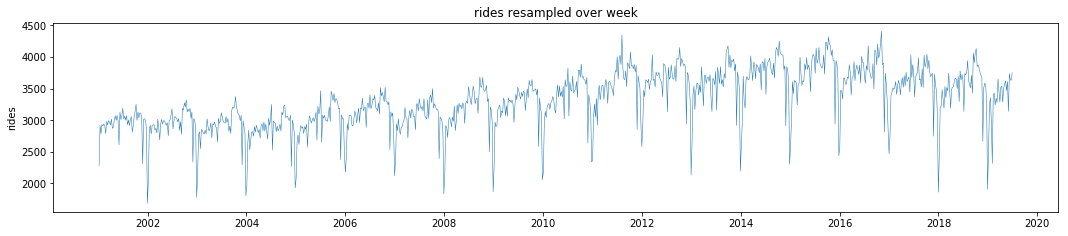

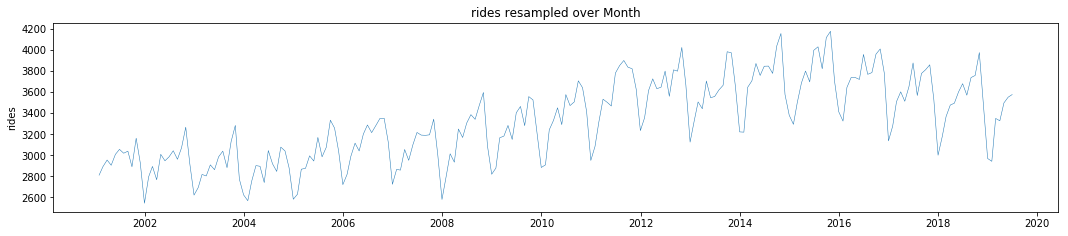

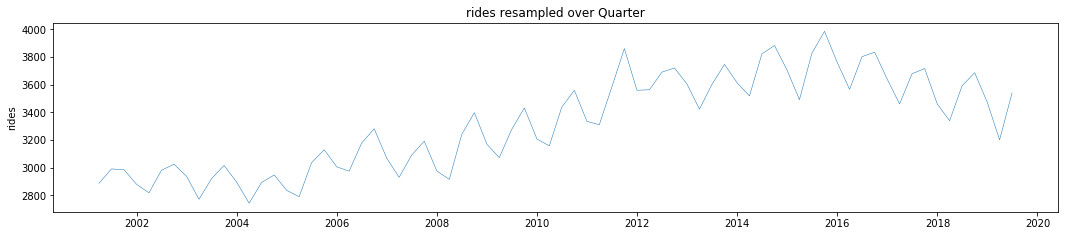

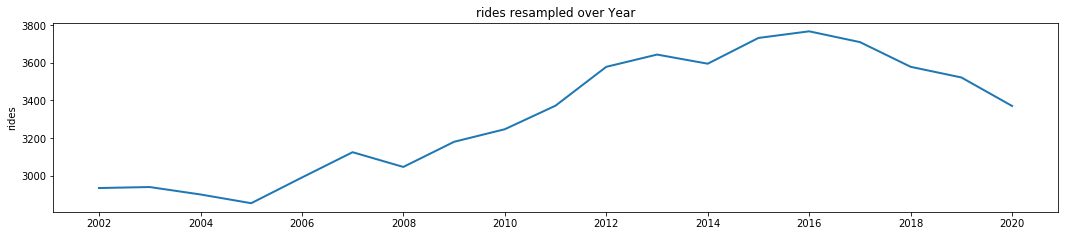

In [34]:
time_sliced_data_by_date =time_sliced_data.loc[:,['date','rides']]


time_sliced_data_by_date.set_index('date',inplace=True)

fig = plt.figure(figsize=(18,16))
ax1 = fig.add_subplot(4,1,1)
#resample over week data
ax1.plot(time_sliced_data_by_date['rides'].resample('W').mean(), linewidth = 0.5)
ax1.set_title('rides resampled over week')
ax1.set_ylabel('rides')

fig = plt.figure(figsize=(18,16))
ax2 = fig.add_subplot(4,1,2)
#resample monthly
ax2.plot(time_sliced_data_by_date['rides'].resample('M').mean(), linewidth = .5)
ax2.set_title('rides resampled over Month')
ax2.set_ylabel('rides')

fig = plt.figure(figsize=(18,16))
ax3 = fig.add_subplot(4,1,3)
#resample Quaterly
ax3.plot(time_sliced_data_by_date['rides'].resample('Q').mean(), linewidth = .5)
ax3.set_title('rides resampled over Quarter')
ax3.set_ylabel('rides')

fig = plt.figure(figsize=(18,16))
ax4 = fig.add_subplot(4,1,4)
#resample Quaterly
ax4.plot(time_sliced_data_by_date['rides'].resample('Y').mean(), linewidth = 2)
ax4.set_title('rides resampled over Year')
ax4.set_ylabel('rides')





The above graph couple of more interesting insights about the rides distribution:
- All the sampled data tell a story that the rides have increased over time till 2016 and started to decrease from 2016 to date
- Year end tends to have more number of rides
- Quarter 4 tends to have more number of rides than Q1, Q2, Q3
- Year 2005, 2009 seems to have lowest number of rides compared with past history, knowing the answer why the past rides in 2005 and 2009 had low of number of rides would help to improve rides for 2019 and beyond

Understanding at a more granular level of rides distribution like 
- what day people travel the most,
- which quarter the rides are expected to be high,
- of all the month which month get hit by most rides 

would help the CTA authorities to manage the infrastructure better

Text(0.5, 1.0, 'Average rides per year')

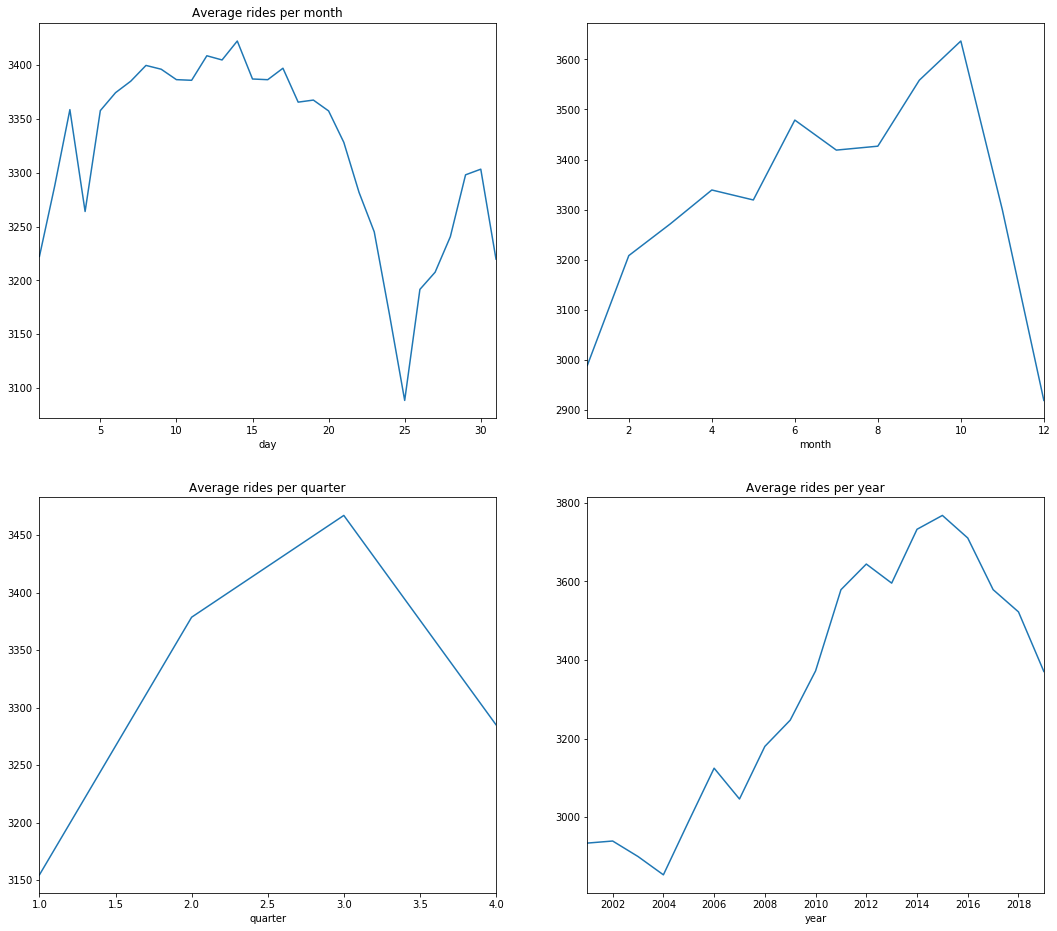

In [35]:
fig = plt.figure(figsize=(18,16))
ax1 = fig.add_subplot(2,2,1)
time_sliced_data.groupby('day').rides.mean().plot()
ax1.set_title('Average rides by day')



ax2 = fig.add_subplot(2,2,2)
time_sliced_data.groupby('month').rides.mean().plot()
ax1.set_title('Average rides per month')

ax3 = fig.add_subplot(2,2,3)
time_sliced_data.groupby('quarter').rides.mean().plot()
ax3.set_title('Average rides per quarter')



ax4 = fig.add_subplot(2,2,4)
time_sliced_data.groupby('year').rides.mean().plot()
ax4.set_title('Average rides per year')


- Day 8 to Day 20 (mid of the month) of the month usually get most rides 
- 7th to 11th month of the year seems to have highest traffic, might be beacause of the start of holiday season
- 3rd quarter has a highest number of rides when compared to other quarter
- Year 2015 and 2016 had maximum number of rides

What is the yearly trend of the rides? We could use pandas pivot table that stores in MultiIndex objects on the index and columns of the result DataFrame.

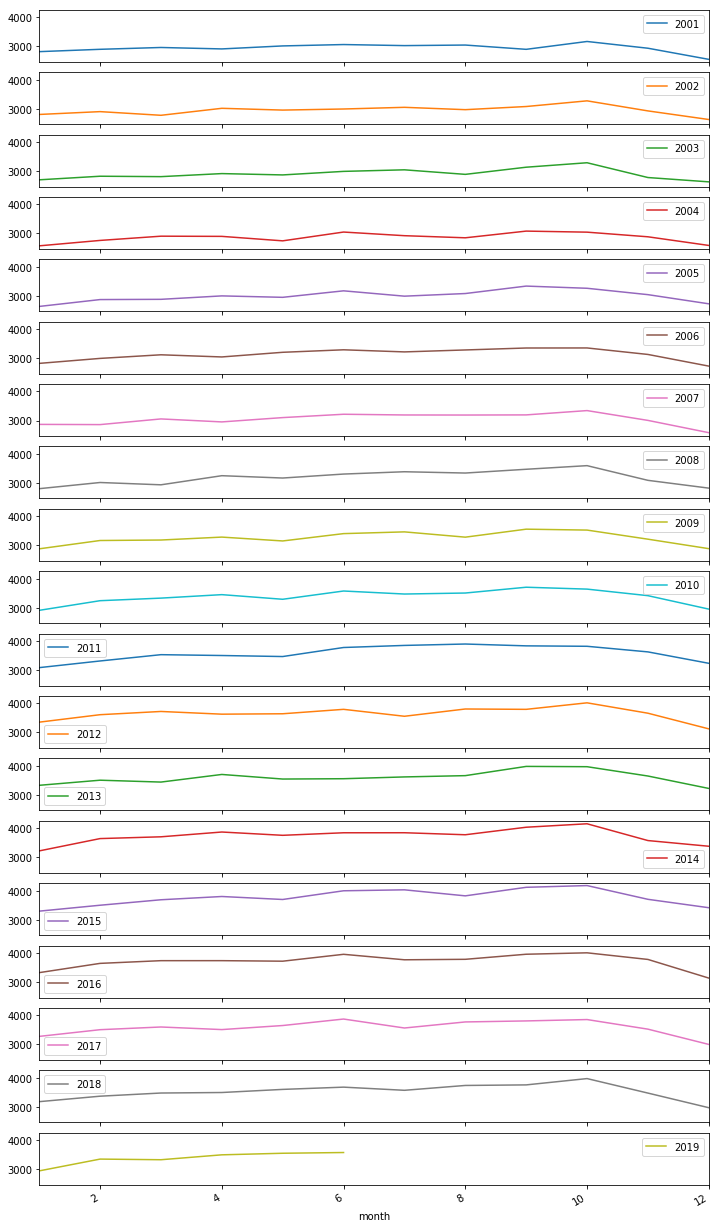

In [36]:
pivot_table = pd.pivot_table(time_sliced_data, values = "rides", columns = "year", index = "month")
pivot_table.plot(subplots = True, figsize=(12, 12*2), layout=(19, 1), sharey=True);

Pivot table gives an insight that the rides follow a very similar pattern each year, of having least number of rides in 1st month and max number of rides in 10th and 11th month


## Understanding the significance of  `Saturday`/`Sunday or holiday`/`Weekday`

preprocessing of the data

In [37]:
def construct_day_hash(x):
    if x['sun_holiday'] == 1:
        return 'sunday/holiday'
    if x['saturday'] == 1:
        return 'saturday'
    if x['weekday'] == 1: #sunday
        return 'weekday'

df = pd.DataFrame()
df['day'] = time_sliced_data.apply(construct_day_hash, axis = 1)


In [38]:
df['rides'] = time_sliced_data['rides']
df['year'] = time_sliced_data['year']

In [39]:
df.head()

,day,rides,year
0,sunday/holiday,700,2001
1,sunday/holiday,474,2001
2,sunday/holiday,540,2001
3,sunday/holiday,788,2001
4,sunday/holiday,1763,2001


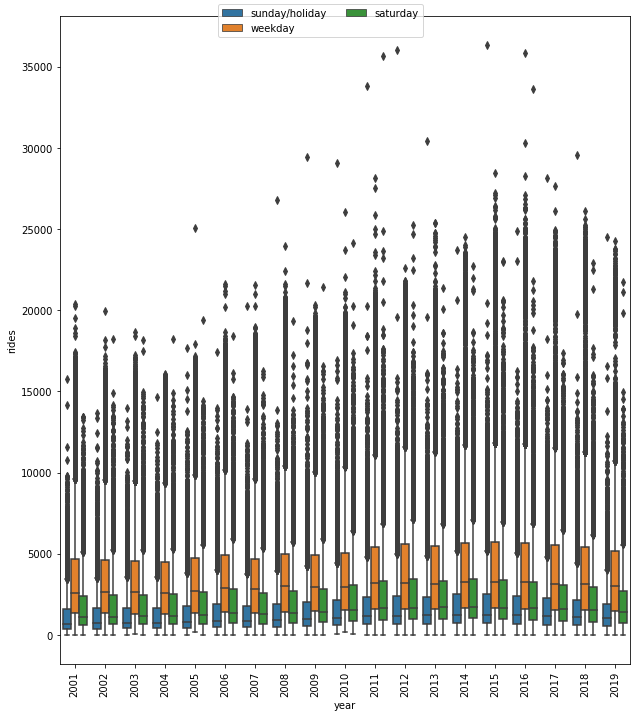

In [40]:
a=plt.figure(figsize=(9,10)) 
sns.boxplot('year','rides', hue='day', data=df)    

a.legend( loc='upper center', ncol=2)
plt.xticks(rotation=90)
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

From the above boxplot we could infer that:
- Weekday tends to have more number of rides
- Followed by Saturday
- Least number of rides can be expected during holiday/Sunday, CTA could lower the frequency of trains during holidays/Sundays

Factor plot to show the trend during the different daytypes

/Users/dkurra/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/dkurra/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Factor plot')

<Figure size 648x720 with 0 Axes>

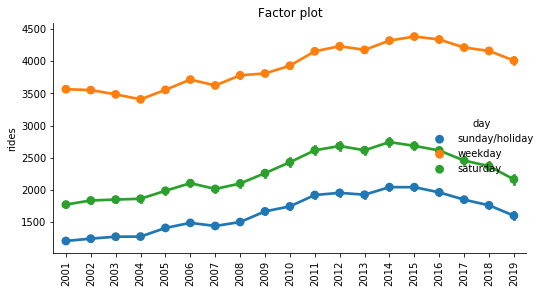

In [41]:
a=plt.figure(figsize=(9,10))
sns.factorplot('year','rides',hue = 'day', data = df, size = 4, aspect = 1.5, legend = True) 


# g = sns.catplot("year", col="rides", col_wrap=4,
#                data=time_sliced_data[time_sliced_data.rides.notnull()],
#                 kind="count", height=2.5, aspect=.8)
plt.xlabel('')
plt.xticks(rotation=90)
plt.tight_layout()     
plt.legend(loc='best');
plt.legend().set_visible(False);
plt.title('Factor plot')                                                             


## Is the times series stationary?

- If a time series is stationary, it implies the lack of broad trends in the data. This is important as a consideration in time series forecasting.
 
- When building models to forecast time series data (like ARIMA), we start by differencing the data (calculating sequentially 𝑥𝑡−𝑥𝑡−1 until we get to a point where the series is stationary. Models account for oscillations but not for trends, and therefore, accounting for trends by differencing allows us to use the models that account for oscillations.

- Once the model has been constructed, we can account for trends separately, by adding the trends component-wise.

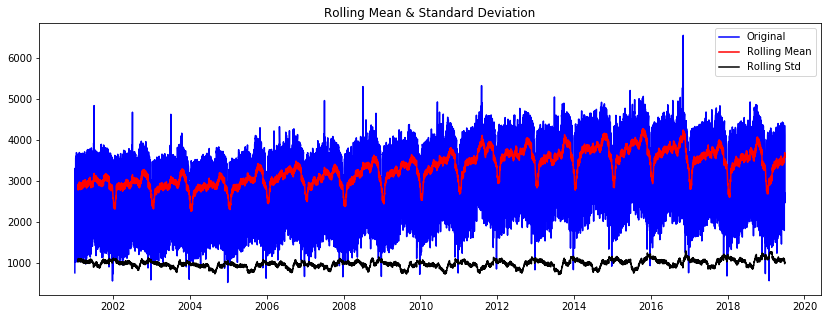

<Results of Dickey-Fuller Test>
Test Statistic                   -4.576790
p-value                           0.000143
#Lags Used                       35.000000
Number of Observations Used    6719.000000
Critical Value (1%)              -3.431324
Critical Value (5%)              -2.861970
Critical Value (10%)             -2.566999
dtype: float64
p-value = 0.00014250920149504537 The series rides is likely stationary.


In [42]:
#ref: https://gist.github.com/kevincdurand1/e8307dfb3e370ca15bdbb97300037c71
df1 = time_sliced_data.loc[:,['date','rides']]
df1.set_index('date',inplace=True)


df2 = df1.resample('D').apply(np.mean)

def test_stationarity(timeseries,  cutoff = 0.05):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    pvalue = dftest[1]
    if pvalue <= cutoff:
        print('p-value = '+ str(pvalue) + ' The series '+ timeseries.name + ' is likely stationary.')
        #return True
    else:
        print('p-value = '+ str(pvalue) + ' The series '+ timeseries.name + ' is likely non-stationary.')
    
test_stationarity(df2.rides.dropna())

From the above results, we could conclude the rides data provided is stationary

## ARIMA (Autoregressive integrated moving average)

Given that data is stationary, we could build model using ARIMA to fit time series data either to understand the data better or to predict the future series

- Captures a suite of different standard temporal structures in a stationary time series by providing a simple yet very powerful method for making forecasts
- The `AR` part indicates that the evolving variable of interest is regressed on its own lagged (i.e., prior) values
- `I` part uses of differencing of raw observations in order to make the time series stationary
- The `MA` part indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past

In [43]:
rides_data = pd.read_csv('./CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')

In [44]:
rides_data["date"] = pd.to_datetime(rides_data["date"])

In [45]:
rides_data_grouped = rides_data.groupby(['station_id', 'daytype', 'date'])['rides'].sum().reset_index()

In [46]:
rides_data_grouped.head()

,station_id,daytype,date,rides
0,40010,A,2001-01-06,613
1,40010,A,2001-01-13,693
2,40010,A,2001-01-20,663
3,40010,A,2001-01-27,677
4,40010,A,2001-02-03,632


In [47]:
rides_data_grouped = rides_data_grouped.set_index('date')
rides_data_grouped.index

DatetimeIndex(['2001-01-06', '2001-01-13', '2001-01-20', '2001-01-27',
               '2001-02-03', '2001-02-10', '2001-02-17', '2001-02-24',
               '2001-03-03', '2001-03-10',
               ...
               '2019-06-17', '2019-06-18', '2019-06-19', '2019-06-20',
               '2019-06-21', '2019-06-24', '2019-06-25', '2019-06-26',
               '2019-06-27', '2019-06-28'],
              dtype='datetime64[ns]', name='date', length=961928, freq=None)

Analysis the daily rides data could be tricky, we could use the the averages daily rides for that month and build the ARIMA model based off that 

In [48]:
y = rides_data_grouped['rides'].resample('MS').mean()

In [49]:
y.shape

(222,)

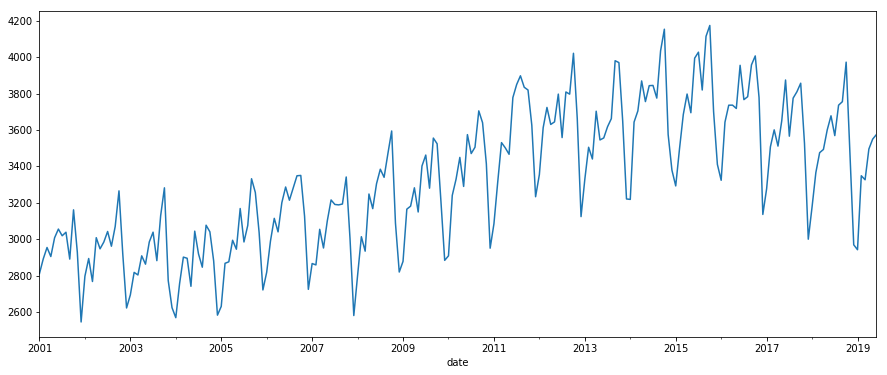

In [50]:
y.plot(figsize=(15, 6))
plt.show()

<Figure size 1008x576 with 0 Axes>

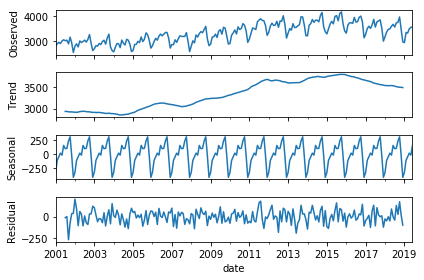

In [64]:
from pylab import rcParams
plt.figure(figsize=(14,8))

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The parameters of the SARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

In [65]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
# parameter for ARIMA and various combination to find the best set of params
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

minimum_aic = float('inf')
best_params = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < minimum_aic:
                best_param = param
                best_param_seasonal = param_seasonal
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/Users/dkurra/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4215.921963975899
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3728.442166887544
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2669.653264695993
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2524.044979601928
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2675.6212252168725
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2665.995049857306
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2536.3529260030023
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2526.026994250478
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4039.573417867449
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3458.288431518232
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2623.6513779473335
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2477.11805349752
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2644.4605237816268


/Users/dkurra/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2623.877300544922
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2501.4516688792137
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2479.1180238696634
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2977.397993956784
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2709.0494015675217
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2650.643722500089
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:2453.024888157022
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:2643.5145168033105
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:2605.252651896617
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:2503.416936452977
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:2442.1331113527986
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:2965.4756740814837
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2694.231226904682
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:2542.351845974452
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2354.0706788325856
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:2563.3122648973344
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2491.189910849304
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:2409.13627401938
ARI

In [66]:
best_param

(1, 1, 1)

In [67]:
best_param_seasonal

(1, 1, 1, 12)

After searching for the best parmater, lets build a model with best_param and best_param_sesonal

In [68]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=best_param,
                                seasonal_order=best_param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2176      0.116     -1.868      0.062      -0.446       0.011
ma.L1         -0.5435      0.097     -5.623      0.000      -0.733      -0.354
ar.S.L12       0.1950      0.080      2.429      0.015       0.038       0.352
ma.S.L12      -0.8229      0.075    -11.017      0.000      -0.969      -0.676
sigma2      8892.6720   1002.173      8.873      0.000    6928.449    1.09e+04


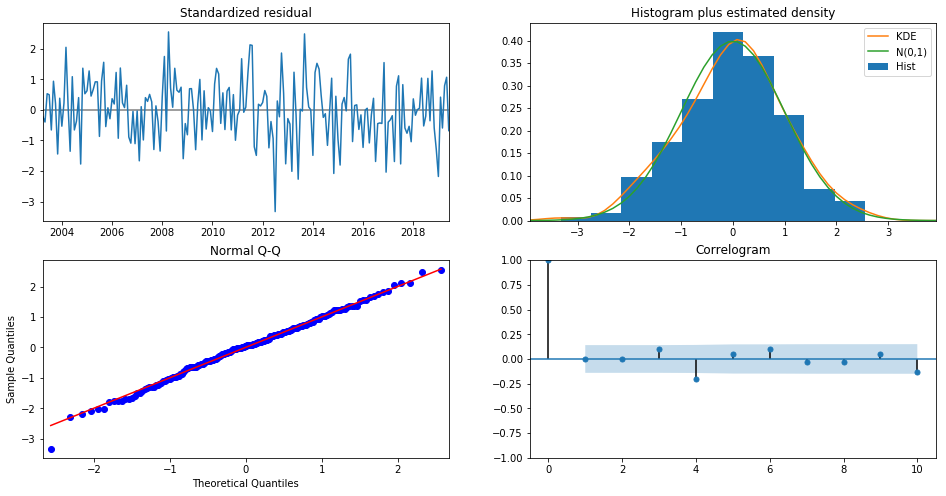

In [69]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

- plot residual errors suggests that  there may still be some trend information not captured by the mode
- density plot and Normal probability plot of the residual error values suggests the errors are Gaussian and center around zero

## Prediction from ARIMA model


We can predict the rides of 2017 using the historical data and ARIMA model can be used to forecast future time steps

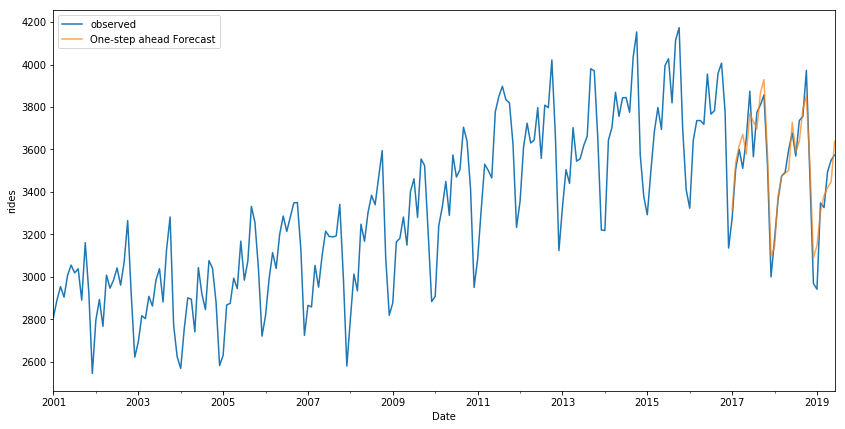

In [70]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
ax = y['2001':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('rides')
plt.legend()
plt.show()

ARIMA Prediction with confidence intervals

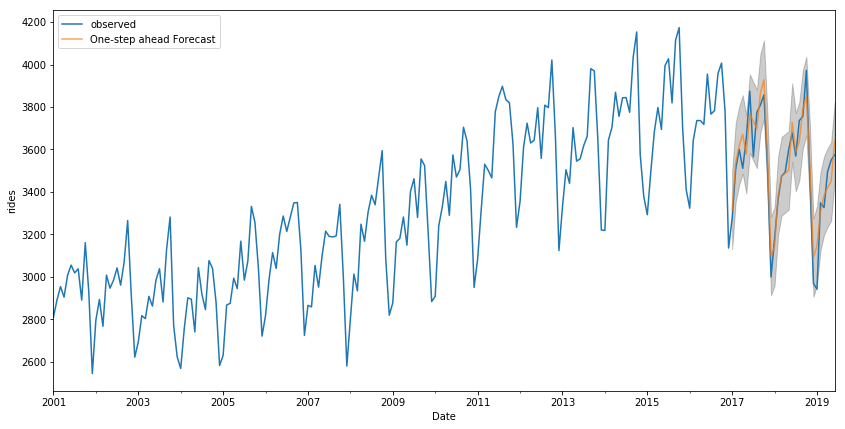

In [71]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)

ax = y['2001':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
pred_ci = pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('rides')
plt.legend()
plt.show()

In [72]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 7421.12
The Root Mean Squared Error of our forecasts is 86.15


## Forecasts from ARIMA model

Get forecats for next 20 steps starting from 2019:

`steps`: If an integer, the number of steps to forecast from the end of the sample. Can also be a date string to parse or a datetime type. However, if the dates index does not have a fixed frequency, steps must be an integer. Default

/Users/dkurra/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


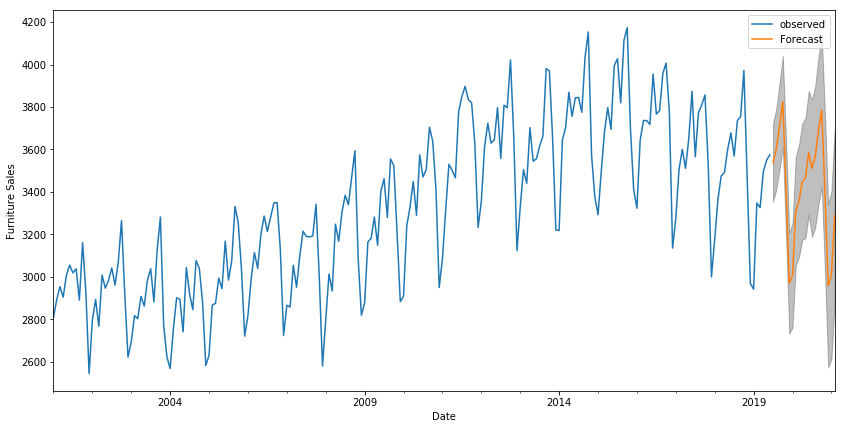

In [73]:
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Forecasting using Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.[?]

In [74]:
from fbprophet import Prophet

In [111]:
rides_data = pd.read_csv('./CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')

In [112]:
rides_data["date"] = pd.to_datetime(rides_data["date"])

To start with we will ignore the complexity of stations, and try to forecast only the total numbers of rides that would happen on given day at CTA irrespective of the stations

In [113]:
rides_data_grouped = rides_data.groupby(['station_id', 'daytype', 'date'])['rides'].sum().reset_index()

Historical rides data from 2001 to 2016 is used for building the time series model. 2017 to end is used for predicting and forecasting

In [114]:
split_date = '01-01-2017'
rides_data_train = rides_data_grouped.loc[rides_data_grouped.date <= split_date].copy()
rides_data_test = rides_data_grouped.loc[rides_data_grouped.date > split_date].copy()

In [115]:
rides_data_train.head()

,station_id,daytype,date,rides
0,40010,A,2001-01-06,613
1,40010,A,2001-01-13,693
2,40010,A,2001-01-20,663
3,40010,A,2001-01-27,677
4,40010,A,2001-02-03,632


In [116]:
rides_data_grouped.shape

(961928, 4)

- Holidays or other recurring events can be injected into the model by creating a Pandas DataFrame
- It has two columns (holiday and ds) and a row for each occurrence of the holiday. 
- Include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made)
- If they won’t repeat in the future, Prophet will model them and then not include them in the forecast [4]

Create a holidays dataFrame to give insights about historical holiday data to Prophet

In [117]:


holidays = pd.DataFrame({
  'holiday': 'sunday_holidat',
  'ds': rides_data_train[rides_data_train.daytype == 'U'][['date']].set_index('date').index,
  'lower_window': 0,
  'upper_window': 1,
})


Prophet expects the timeseries data to be with two columns name `ds` and `y`

In [118]:
rides_data_train = rides_data_train.rename(columns={'date':'ds', 'rides':'y'})[['ds', 'y']]

- Prophet will by default fit weekly and yearly seasonalities if the time series is more than two cycles long
- Pass the `holiday` datafrmae creates to Prophet
- Add USA holidays to the model


In [119]:
model = Prophet(holidays= holidays)
model.add_country_holidays(country_name='US')


In [120]:
model.fit(rides_data_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- Predictions are then made on a dataframe with a column ds containing only dates for which we are interested to make predictions
-  helper method Prophet.make_future_dataframe can be used to extend a DataFrame in future
- Here we are trying to make prediction for next 365 days starting from 2017-01-01

In [121]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
831244,2017-12-28
831245,2017-12-29
831246,2017-12-30
831247,2017-12-31
831248,2018-01-01


Lets predict next 365 days in the future

In [122]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
831244,2017-12-28,3795.860204,-170.199295,7486.858080
831245,2017-12-29,3764.682264,-269.763735,7531.012649
831246,2017-12-30,2131.535158,-1613.513151,5743.042323
831247,2017-12-31,3243.948359,-350.822133,7309.332614
831248,2018-01-01,4153.748972,317.544999,7853.313675


- Forecast is a pandas dataframe with many intersting variables
- The predict method's output forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

Prohet helps with data visualization by by calling the Prophet.plot method and passing in the forecast dataframe.

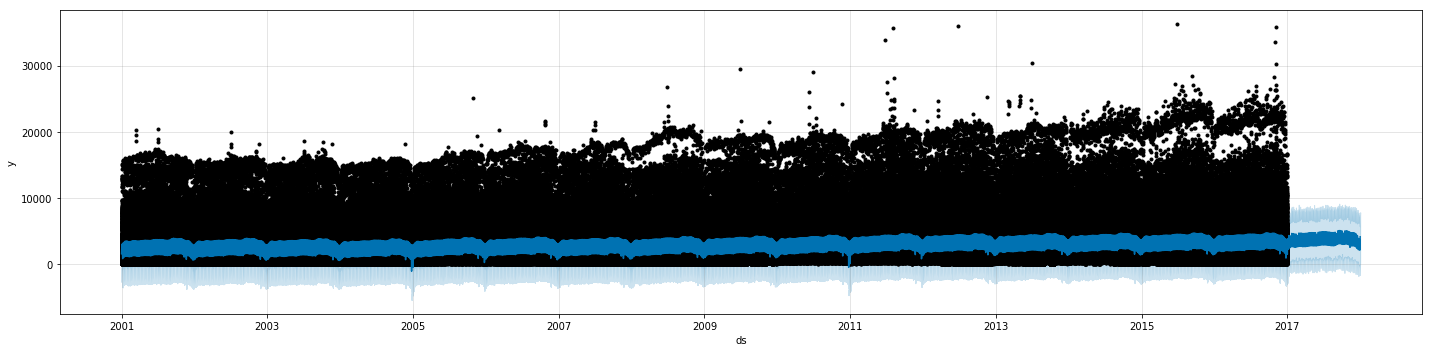

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
fig = model.plot(forecast, ax=ax)

-  Prophet.plot_components method can be used to visualize the forecast components
-  Here is great visualization explaining the daily, weekly and yearly trends

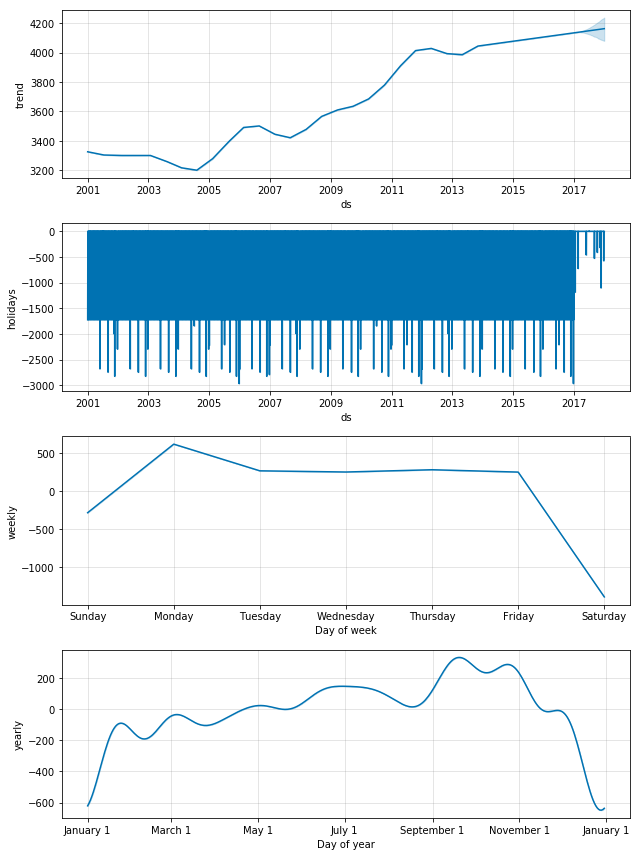

In [ ]:
fig2 = model.plot_components(forecast)


- The overall trend from year 2001 to 2017 is shown in plot 1
- plot 2 shows the effect on hoidays on number of rides
- plot3 shows weekly trend of the rides data
- plot 4 shows yearly trend

- cross-validation to assess prediction performance on a horizon of 365 days, with intial set to three times the horizon and cutt offs are made every half of the horizon
- On this 19 year time series, this corresponds to 25 total forecasts

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 25 forecasts with cutoffs between 2004-01-05 00:00:00 and 2016-01-02 00:00:00


In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

## Model for rides data sampled over month

In [75]:
rides_data = pd.read_csv('./CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')

In [76]:
rides_data["date"] = pd.to_datetime(rides_data["date"])

In [77]:
rides_data_grouped = rides_data.groupby(['station_id', 'daytype', 'date'])['rides'].sum().reset_index()

In [78]:
split_date = '01-01-2017'
rides_data_train = rides_data_grouped.loc[rides_data_grouped.date <= split_date].copy()
rides_data_test = rides_data_grouped.loc[rides_data_grouped.date > split_date].copy()

In [79]:
rides_data_grouped.head()

,station_id,daytype,date,rides
0,40010,A,2001-01-06,613
1,40010,A,2001-01-13,693
2,40010,A,2001-01-20,663
3,40010,A,2001-01-27,677
4,40010,A,2001-02-03,632


In [80]:
rides_data_train_grouped = rides_data_train.set_index('date')
rides_data_train_grouped.index

DatetimeIndex(['2001-01-06', '2001-01-13', '2001-01-20', '2001-01-27',
               '2001-02-03', '2001-02-10', '2001-02-17', '2001-02-24',
               '2001-03-03', '2001-03-10',
               ...
               '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21',
               '2016-12-22', '2016-12-23', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='date', length=830884, freq=None)

Resample rides data with `MS` or month start frequency

In [81]:
y = rides_data_train_grouped['rides'].resample('MS').mean()

In [82]:
rides_data_train_monthly = y.to_frame().reset_index().rename(columns={'date':'ds', 'rides':'y'})[['ds', 'y']]

In [83]:
rides_data_train_monthly.head()

,ds,y
0,2001-01-01,2811.003660
1,2001-02-01,2891.538247
2,2001-03-01,2954.540380
3,2001-04-01,2904.902364
4,2001-05-01,3008.067490


In [84]:
holidays = pd.DataFrame({
  'holiday': 'sunday_holidat',
  'ds': rides_data_train[rides_data_train.daytype == 'U'][['date']].set_index('date').index,
  'lower_window': 0,
  'upper_window': 1,
})


In [85]:
model = Prophet(holidays= holidays)
model.add_country_holidays(country_name='US')

In [86]:
model.fit(rides_data_train_monthly)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [87]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
553,2017-12-28
554,2017-12-29
555,2017-12-30
556,2017-12-31
557,2018-01-01


In [88]:
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
553,2017-12-28,4430.401212,4238.369442,4613.346733
554,2017-12-29,4184.786452,3999.646404,4386.545931
555,2017-12-30,3920.557233,3725.042192,4124.501313
556,2017-12-31,3642.320292,3454.693050,3848.064969
557,2018-01-01,3298.789316,3093.174011,3479.473243


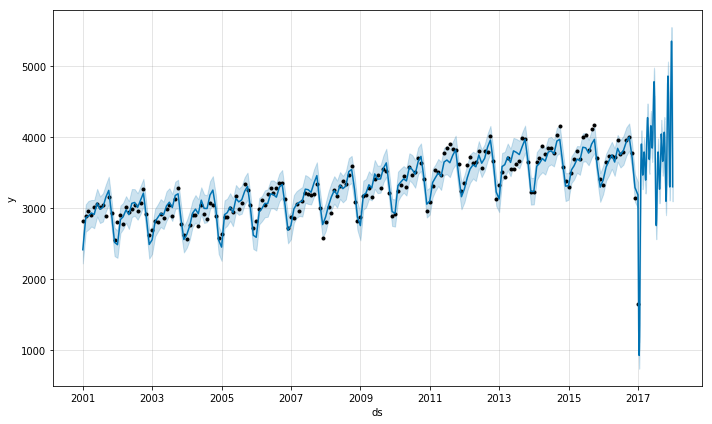

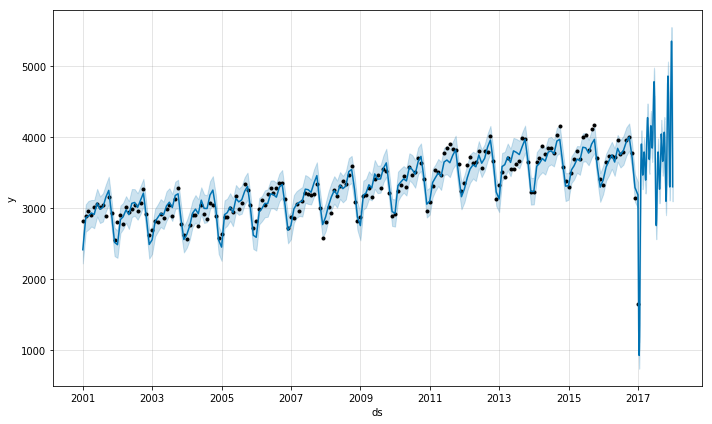

In [89]:
model.plot(forecast)


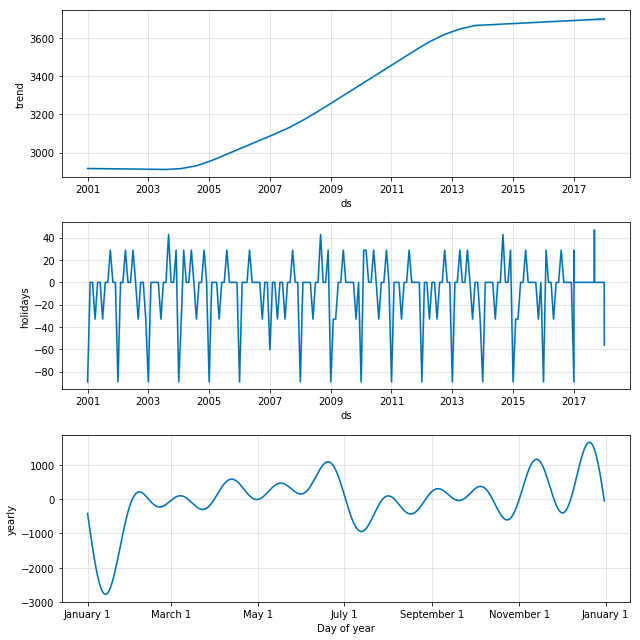

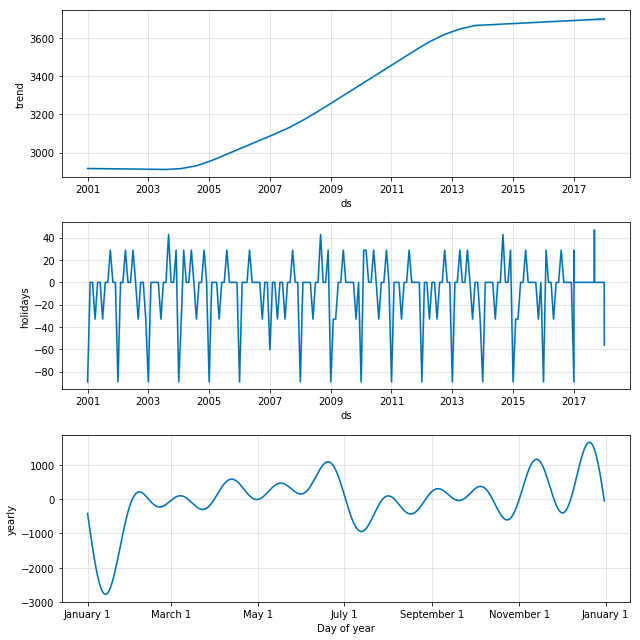

In [90]:
model.plot_components(forecast)


In [110]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 25 forecasts with cutoffs between 2004-01-05 00:00:00 and 2016-01-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2004-01-06,216.081018,126.978818,300.318092,163,2004-01-05
1,2004-01-07,214.117397,126.489895,303.848810,156,2004-01-05
2,2004-01-08,222.238386,134.490439,304.841502,167,2004-01-05
3,2004-01-09,210.972025,125.886746,296.545998,142,2004-01-05
4,2004-01-10,-98.277882,-183.973324,-11.168754,2,2004-01-05


In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

## Model rides for a single Station ( Central Park 279116600) using Prophet

In [92]:
rides_data = pd.read_csv('./CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')

In [93]:
rides_data["date"] = pd.to_datetime(rides_data["date"])

In [94]:
rides_data.head()

,station_id,stationname,date,daytype,rides
0,40850,Library,2004-10-09,A,1057
1,40780,Central Park,2010-06-18,W,1154
2,41500,Montrose-Brown,2001-10-30,W,2116
3,40500,Washington/State,2006-10-26,W,0
4,41090,Monroe/State,2010-07-07,W,9431


Fetch all the rides since 2001 that belongs to `Central Park`

In [95]:
rides_data_central_park = rides_data[rides_data.stationname == 'Central Park' ]

In [96]:
rides_data_central_park['rides'].sum()

5263249

In [97]:
rides_data_central_park_grouped = rides_data_central_park.groupby(['station_id', 'daytype', 'date'])['rides'].sum().reset_index()

In [98]:
split_date = '01-01-2017'
rides_data_central_park_grouped_train  = rides_data_central_park_grouped.loc[rides_data_grouped.date <= split_date].copy()
rides_data_central_park_grouped_test = rides_data_central_park_grouped.loc[rides_data_grouped.date > split_date].copy()

In [99]:
rides_data_central_park_grouped_train.shape

(5845, 4)

In [100]:
holidays = pd.DataFrame({
  'holiday': 'sunday_holidat',
  'ds': rides_data_central_park_grouped_train[rides_data_central_park_grouped_train.daytype == 'U'][['date']].set_index('date').index,
  'lower_window': 0,
  'upper_window': 1,
})


In [101]:
rides_data_central_park_grouped_train = rides_data_central_park_grouped_train.rename(columns={'date':'ds', 'rides':'y'})[['ds', 'y']]

In [102]:
model = Prophet(holidays= holidays)
model.add_country_holidays(country_name='US')


In [103]:
model.fit(rides_data_central_park_grouped_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [104]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
6205,2017-12-28
6206,2017-12-29
6207,2017-12-30
6208,2017-12-31
6209,2018-01-01


In [105]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6205,2017-12-28,1072.135322,945.187619,1207.538915
6206,2017-12-29,1042.744158,912.629098,1173.831626
6207,2017-12-30,643.702308,510.842584,778.597874
6208,2017-12-31,888.634150,759.988209,1024.535714
6209,2018-01-01,1108.740468,977.020205,1239.673351


forecast with confidence intervals

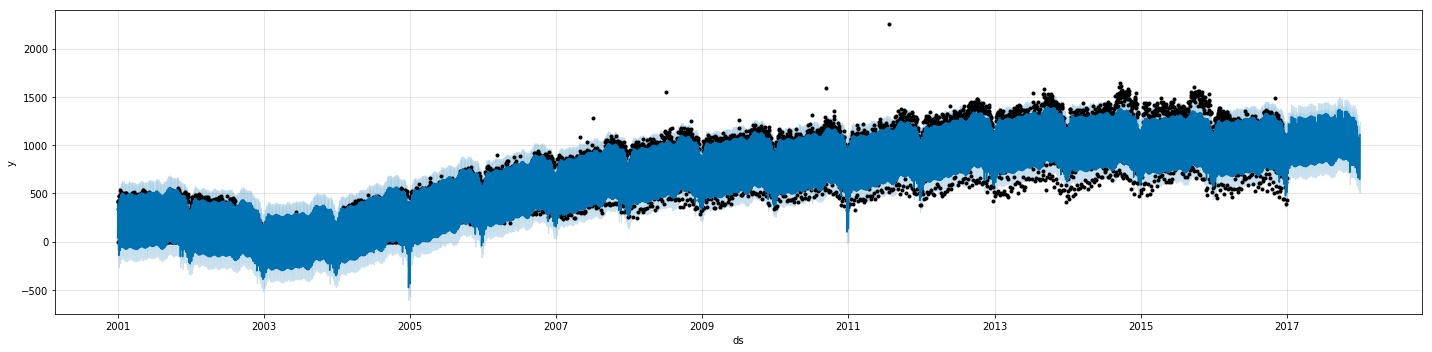

In [106]:
f, ax = plt.subplots(1)
f.set_figheight(5)b
f.set_figwidth(20)
fig = model.plot(forecast, ax=ax)

forecasts into the furture with checkpoints

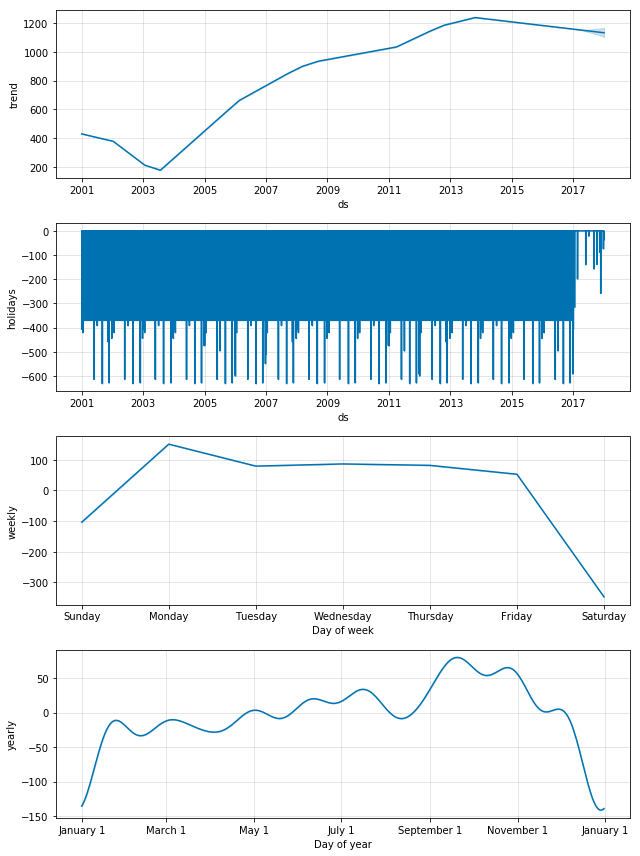

In [107]:
fig2 = model.plot_components(forecast)


trends for `Central Park` station 

In [108]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 25 forecasts with cutoffs between 2004-01-05 00:00:00 and 2016-01-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2004-01-06,216.081018,129.204385,303.590603,163,2004-01-05
1,2004-01-07,214.117397,126.100495,300.696972,156,2004-01-05
2,2004-01-08,222.238386,132.714310,316.265606,167,2004-01-05
3,2004-01-09,210.972025,125.747763,300.350349,142,2004-01-05
4,2004-01-10,-98.277882,-184.051094,-12.705640,2,2004-01-05


performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). 

In [109]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,coverage
0,36 days 12:00:00,12091.244000,109.960193,73.874342,0.780702
1,37 days 00:00:00,12037.000024,109.713263,73.843334,0.778677
2,37 days 12:00:00,11995.524921,109.524084,73.539326,0.778509
3,38 days 00:00:00,12116.746552,110.076094,74.069856,0.776569
4,38 days 12:00:00,12090.748391,109.957939,74.020013,0.777412


Metrics is provided for various cuttoffs, for 36 days in future has minimum mse, rmse, mae of 12091, 109, 73




Conclusion:

- This notebook provides interesting aspects of the rides data of CTA.
- We have shown how the rides trend from start of 2001 to 2019
- Discusssed how the rides trend is effected by weekday/holiday/Saturday
- Discussed how the day of the month, quarter of the year, week of the month could effect the rides
- Discussed the stationarity and normality of the data
- We have use statistical ARIMA based methods to predict and forecast future rides
- We have used Facebook's Prophet tool to forecast future rides
- Using Prophet we analysed and forecasted the rides of one of the most famous station `Central Park`
- Future work: Verify how LSTM and other traditional ML models could be used to analyse the data. This might  need extensive feature engineering, like inclusion of lag features, injected the seasonality pattern etc.
- Convert the rides to Log tranformation before feeding into the models to avoid huge computations


Reference:
    
- https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
- https://facebook.github.io/
- https://arxiv.org/pdf/1709.08055v2.pdf